<a href="https://colab.research.google.com/github/shinchacoffee/CIFAR10_practice/blob/resnet-ver/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision

In [18]:
random_seed=1
train_batch_size=100
test_batch_size=1000
n_epochs=1
torch.manual_seed(random_seed)

In [19]:
train_norm_load = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('/files/', train = True,
                                 transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor()
                                            ]),
                                            download = True),
                            batch_size=train_batch_size, shuffle = True)

Files already downloaded and verified


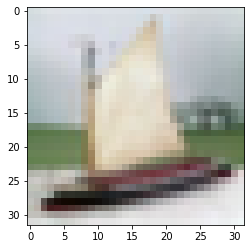

In [20]:
import matplotlib.pyplot as plt
fig2=plt.figure()
for x,y in train_norm_load:
  xx=torch.movedim(x[0], (0,1,2), (2,0,1))
  plt.imshow(xx)
  break

In [21]:
RGB_sum = torch.zeros(3)
RGB_sum_sq = torch.zeros(3)
for x,y in train_norm_load:
  RGB_sum += torch.mean(x, dim=(0,2,3))#*x.shape[0]
  RGB_sum_sq += torch.mean(x*x, dim=(0,2,3))#*x.shape[0]
RGB_mean = RGB_sum / len(train_norm_load)
RGB_std  = (RGB_sum_sq / len(train_norm_load) - RGB_mean ** 2)**0.5
print(RGB_mean,RGB_std)

tensor([0.4914, 0.4822, 0.4465]) tensor([0.2470, 0.2435, 0.2616])


In [22]:


train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('/files/', train = True,
                                 transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                                RGB_mean, RGB_std )
                                            ]),
                                            download = True),
                            batch_size=train_batch_size, shuffle = True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR10('/files/', train = False,
                                 transform = torchvision.transforms.Compose([
                                            torchvision.transforms.ToTensor(),
                                            torchvision.transforms.Normalize(
                                                (0.5, 0.5, 0.5), (0.2, 0.2, 0.2) )
                                            ]), #why not working when without enter?
                                            download = True),
                            batch_size=test_batch_size, shuffle = True)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
RGB_sum = torch.zeros(3)
RGB_sum_sq = torch.zeros(3)
for x,y in train_loader:
  RGB_sum += torch.mean(x, dim=(0,2,3))#*x.shape[0]
  RGB_sum_sq += torch.mean(x*x, dim=(0,2,3))#*x.shape[0]
RGB_mean = RGB_sum / len(train_loader)
RGB_std  = (RGB_sum_sq / len(train_loader) - RGB_mean ** 2)**0.5
print(RGB_mean,RGB_std)

tensor([-7.9392e-07,  3.6231e-07, -5.1742e-07]) tensor([1.0000, 1.0000, 1.0000])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


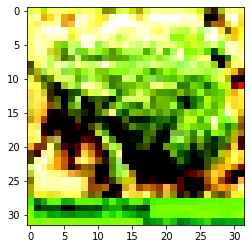

In [24]:
import matplotlib.pyplot as plt
fig1=plt.figure()
for x,y in train_loader:
  xx=torch.movedim(x[0], (0,1,2), (2,0,1))
  plt.imshow(xx)
  break

In [25]:
import torch.nn
import torch.nn.functional
import torch.optim

In [85]:
class My_net(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(3,9,5)
    self.conv2 = torch.nn.Conv2d(9,15,5)
    self.conv2drop = torch.nn.Dropout2d(p=0.5)
    self.skip_conv2 = torch.nn.Conv2d(3,15,13)
    self.line1 = torch.nn.Linear(375,50)
    self.line2 = torch.nn.Linear(50,10)
    self.resid = torch.nn.Linear(375,10)

  def forward(self, signal):
    #print(signal.shape)
    #singal = torch.nn.BatchNorm2d(3)(signal)
    #residconv = torch.nn.functional.max_pool2d(self.skip_conv2(signal),2)
    #print(residconv.shape)
    signal = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv1(signal),2))
    #print(signal.shape)
    #signal = torch.nn.BatchNorm2d(9)(signal)
    #+residconv+residconv
    signal = torch.nn.functional.relu(torch.nn.functional.max_pool2d(self.conv2drop(self.conv2(signal)),2))
    #print(signal.shape)
    signal = torch.nn.BatchNorm2d(15)(signal)
    signal = signal.view(signal.shape[0],-1)
    #print(signal.shape)
    residual = torch.nn.functional.relu(self.resid(signal))
    signal = torch.nn.functional.relu(self.line1(signal))
    signal = torch.nn.LayerNorm(50)(signal)
    signal = torch.nn.functional.dropout(signal,p=0.5)
    #print(signal.shape)
    #signal += residual
    signal = torch.nn.functional.relu(self.line2(signal)+residual)#
    #print(signal.shape)
    return torch.nn.functional.log_softmax(signal)

In [86]:
network = My_net()
#network_nonnorm = My_net()
learnin_rate = 0.003
my_momentum = 0.73
optimizer = torch.optim.SGD(network.parameters(), lr=learnin_rate, momentum=my_momentum)
#optimizer_non = torch.optim.SGD(network_nonnorm.parameters(), lr=learnin_rate, momentum=my_momentum)

In [77]:
network(torch.rand(7,3,32,32))

torch.Size([7, 15, 10, 10])
torch.Size([7, 15, 5, 5])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


tensor([[-2.6629, -2.0013, -2.9132, -0.9024, -2.9132, -2.9132, -2.9132, -2.9132,
         -2.7536, -2.9132],
        [-1.8334, -3.1022, -2.0370, -2.9981, -2.0131, -2.3706, -3.1022, -2.4380,
         -1.5577, -3.1022],
        [-0.4330, -3.5589, -3.1119, -3.5589, -3.3443, -3.5589, -3.0431, -3.5589,
         -3.5589, -2.5058],
        [-2.9746, -2.4574, -2.4722, -2.9746, -1.9210, -2.3913, -2.3718, -2.4787,
         -1.3410, -2.9746],
        [-2.6549, -2.6549, -2.5544, -2.5433, -1.3541, -2.6549, -2.6549, -2.6549,
         -2.3362, -1.9860],
        [-2.6855, -1.5664, -2.4855, -3.0198, -2.7329, -2.5465, -1.7544, -2.6792,
         -1.8509, -3.0198],
        [-2.9012, -2.2948, -1.7166, -2.6253, -1.6346, -2.3272, -2.9012, -2.7517,
         -2.0727, -2.9012]], grad_fn=<LogSoftmaxBackward>)

In [29]:
train_losses = []
train_counter = []
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()

    #rotator = torchvision.transforms.RandomRotation(degrees=(-10, 10))
    #data = rotator(data)
    #prob=torch.rand(1)
    #if prob[0] > 0.5:
    #  data = torchvision.transforms.Grayscale(num_output_channels=3)(data)
    my_transforms = torch.nn.ModuleList([#torchvision.transforms.ColorJitter(), #useless cause by default is zero
                                         #torchvision.transforms.RandomGrayscale(p=0.2),
                                         #torchvision.transforms.RandomRotation(degrees=(-10, 10)),
                                         #torchvision.transforms.RandomPerspective(),
                                         torchvision.transforms.RandomVerticalFlip(p=0.5)#,
                                         #torchvision.transforms.GaussianBlur(3, sigma=(0.1, 1.0)),
                                         ])
    randtran = torchvision.transforms.RandomApply(transforms=my_transforms, p=0.007)
    data = randtran(data)

    output = network(data)
    loss = torch.nn.functional.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % 10 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))


In [30]:
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += torch.nn.functional.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [88]:
n_epochs=90
for epoch in range(1, n_epochs+1):
  train(epoch)

test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	Loss: 1.326442
Train Epoch: 1 [1000/50000 (2%)]	Loss: 1.420883
Train Epoch: 1 [2000/50000 (4%)]	Loss: 1.624877
Train Epoch: 1 [3000/50000 (6%)]	Loss: 1.592620
Train Epoch: 1 [4000/50000 (8%)]	Loss: 1.514460
Train Epoch: 1 [5000/50000 (10%)]	Loss: 1.563916
Train Epoch: 1 [6000/50000 (12%)]	Loss: 1.455742
Train Epoch: 1 [7000/50000 (14%)]	Loss: 1.546412
Train Epoch: 1 [8000/50000 (16%)]	Loss: 1.586092
Train Epoch: 1 [9000/50000 (18%)]	Loss: 1.414362
Train Epoch: 1 [10000/50000 (20%)]	Loss: 1.379462
Train Epoch: 1 [11000/50000 (22%)]	Loss: 1.587538
Train Epoch: 1 [12000/50000 (24%)]	Loss: 1.334047
Train Epoch: 1 [13000/50000 (26%)]	Loss: 1.535444
Train Epoch: 1 [14000/50000 (28%)]	Loss: 1.494007
Train Epoch: 1 [15000/50000 (30%)]	Loss: 1.578567
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.556843
Train Epoch: 1 [17000/50000 (34%)]	Loss: 1.464084
Train Epoch: 1 [18000/50000 (36%)]	Loss: 1.545619
Train Epoch: 1 [19000/50000 (38%)]	Loss: 1.664556
Train Epoch: 1 [20

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1592, Accuracy: 5999/10000 (60%)



In [89]:
test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 1.1574, Accuracy: 5975/10000 (60%)

